Importing Required Packages

In [1]:
import math
from sklearn import neighbors
import os
import os.path
import pickle
import face_recognition
import math
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import accuracy_score

ALLOWED_EXTENSIONS = {'png', 'jpg', 'pgm'}

Function to train the model

In [2]:
def training_knn(training_dir, model_dest_path=None, no_of_neighbors=None, knn_algo='ball_tree'):
    X = []
    y = []



    # looping each person of training set
    for class_dir in os.listdir(training_dir):
        print(f"Processing Person:{class_dir}")
        if not os.path.isdir(os.path.join(training_dir, class_dir)):
            continue

        # looping through each image of person
        for img_path in os.listdir(os.path.join(training_dir, class_dir)):
            if os.path.splitext(img_path)[1][1:] not in ALLOWED_EXTENSIONS:
                continue
            image = face_recognition.load_image_file(os.path.join(training_dir,class_dir,img_path))
            face_bounding_boxes = face_recognition.face_locations(image)

            if len(face_bounding_boxes) != 1:
                # either no or many person
                continue
            else:
                # Add face encoding for current image to the training set
                X.append(face_recognition.face_encodings(image, known_face_locations=face_bounding_boxes)[0])
                y.append(class_dir)

    # taking sq of training set as n neighbors 
    if no_of_neighbors is None:
        no_of_neighbors = int(round(math.sqrt(len(X))))


    # Training the knn classifier
    knn_classifier = neighbors.KNeighborsClassifier(n_neighbors=no_of_neighbors, algorithm=knn_algo, weights='distance')
    knn_classifier.fit(X, y)

    # Save the trained KNN classifier
    if model_dest_path is not None:
        with open(model_dest_path, 'wb') as f:
            pickle.dump(knn_classifier, f)

    return knn_classifier


Function to make predictions given image path using the trained model

In [3]:
def predict_knn(img_path, knn_classifier=None, model_path=None, distance_threshold=0.5) :

    if not os.path.isfile(img_path) or os.path.splitext(img_path)[1][1:] not in ALLOWED_EXTENSIONS:
        raise Exception("Invalid image path: {}".format(img_path))


    if knn_classifier is None and model_path is None:
        raise Exception("No KNN classifier passed")

    # Load a trained KNN model (if one was passed in)
    if knn_classifier is None:
        with open(model_path, 'rb') as f:
            knn_classifier = pickle.load(f)

    frame = face_recognition.load_image_file(img_path)
    face_locations = face_recognition.face_locations(frame)

    # no face detected case
    if len(face_locations) == 0:
        return []

    # Find encodings for faces in the test image
    faces_encodings = face_recognition.face_encodings(frame, known_face_locations=face_locations)

    # Use the KNN model to find the best matches for the test face
    closest_distances = knn_classifier.kneighbors(faces_encodings, n_neighbors=1)
    are_matches = [closest_distances[0][i][0] <= distance_threshold for i in range(len(face_locations))]

    # Predict classes and remove classifications that aren't within the threshold
    return [(pred, loc) if rec else ("unknown", loc) for pred, loc, rec in zip(knn_classifier.predict(faces_encodings), face_locations, are_matches)]


In [4]:
def test(test_dir, model_path):
    y_pred = []
    y_act = []
    for class_dir in os.listdir(test_dir):
        print(f"Processing Person:{class_dir}")
        if not os.path.isdir(os.path.join(test_dir, class_dir)):
            continue

        for img_path in os.listdir(os.path.join(test_dir, class_dir)):
            img_file = os.path.join(test_dir, class_dir,img_path)
            if os.path.splitext(img_path)[1][1:] not in ALLOWED_EXTENSIONS:
                continue

            prediction = predict_knn(img_file, model_path=model_path,distance_threshold=500)
            y_act.append(class_dir)
            if len(prediction) == 0:
                y_pred.append("unknown")
                continue
                
            y_pred.append(prediction[0][0])

    return y_pred, y_act

In [5]:
# Training the knn classifier and saving it too
knn_clf = training_knn("train","analysis_knn.clf")


Processing Person:yaleB11
Processing Person:yaleB12
Processing Person:yaleB13
Processing Person:yaleB15
Processing Person:yaleB16
Processing Person:yaleB17
Processing Person:yaleB18
Processing Person:yaleB19
Processing Person:yaleB20
Processing Person:yaleB21


In [6]:
# making predictions on test set
y_pred, y_act = test("test", model_path="analysis_knn.clf")

yaleB11
yaleB12
yaleB13
yaleB15
yaleB16
yaleB17
yaleB18
yaleB19
yaleB20
yaleB21


Accuracy of the model is 0.945
Visualizing the confusion matrix


<AxesSubplot:>

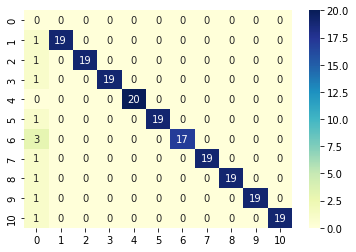

In [7]:
print("Accuracy of the model is",accuracy_score(y_act, y_pred))

print("Visualizing the confusion matrix")
conf = confusion_matrix(y_act, y_pred)
sns.heatmap(conf, annot=True, cmap="YlGnBu")